<a href="https://colab.research.google.com/github/jordicastro/fsDeepLearning/blob/main/Homework3_FSDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Libraries

In [1]:
! pip install cython
! pip install git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI&egg=pycocotools
! pip install git+https://github.com/cocodataset/panopticapi.git#egg=panopticapi
! pip install scipy
! pip installonnx
! pip installonnxruntime
# albumentations: augmentation library
! pip install -U albumentations
# fix: np.float depcrecated
! pip install --upgrade pycocotools

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-yph5k9sb
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-yph5k9sb
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp311-cp311-linux_x86_64.whl size=399198 sha256=e8218cfac485ef0b52c65b2263f50447989cb2be8dcf144833fa1c1f1a42b89f
  Stored in directory: /tmp/pip-ephem-wheel-cache-xg5tr5yn/wheels/6d/69/75/358c50a37672dfda8d74ba3b30ec49fb75d52f7c081886d503
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.8
    Uninstalling pycocotools-2.0.8:
      Successfully uninstalled pycocotools-2.0.8
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-5cvqd2x6/panopticapi_28dbe0c9060f4002924f97cc33e2ae57
  Running com

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Decompress Data and Code

In [3]:
# %cd ..
! ls
! ls drive/MyDrive/_ColabFiles/hw3_data/
! unzip -qq detr.zip -d /content/
! unzip -qq drive/MyDrive/_ColabFiles/hw3_data/license-plate-detection-datasets.zip -d /content/
%cd detr

detr.zip  drive  sample_data
detr.zip  license-plate-detection-datasets.zip
/content/detr


## Starting Training

We will start training via torchrun for distributed training.

```bash
torchrun --nnodes=${NUM_MACHINES} --nproc-per-node=${NUM_GPUS_PER_MACHINE} \
    main.py --device cuda \
    --num_classes 1 \
    --dataset_file character \
    --coco_path ${DATA_DIR} \
    --backbone resnet50 \
    --output_dir ckpts/detr-lp-r50 \
    --batch_size 2 \
    --num_queries 10

```

DATA_DIR: Define the path to the dataset folder.

NUM_MACHINES: Number of machines you are using to train your model.

NUM_GPUS_PER_MACHINE: Number of GPUs per machine you are using to train your model.

num_queries: Number of queries in the Transformer (should be higher than maximum number of bounding boxes per image).

In [5]:
# Start Training
# one node (machine) with one process (GPU)
    # cuda: uses GPU
    # num_classes: license plate is the only class
    # feature extractor (backbone): resnet50, TODO: try resnet101 for better performance
    # output_dir: checkpoint directory
    # batch_size: 2, more batches more efficient training, more memory TODO: try 4 or 8
    # num_queries: 10, number of objects the model can detect per image: TODO: try 5, 50

! torchrun --nnodes=1 --nproc-per-node=1 \
    main.py --device cuda \
    --num_classes 1 \
    --dataset_file character \
    --coco_path /content/license-plate-detection-datasets/ \
    --backbone resnet50 \
    --output_dir ckpts/detr-lp-r50 \
    --batch_size 2 \
    --num_queries 10 \
    --epochs 350 \
    --resume ckpts/detr-lp-r50/checkpoint0199.pth \
    --start_epoch 200 \
    # --lr 1e-4 \
    # --lr_backbone 1e-5 \
    # batch size default: 2
    # --batch_size 2 \
    # num epochs default: 300

Streaming output truncated to the last 5000 lines.
Epoch: [308]  [420/790]  eta: 0:02:41  lr: 0.000010  class_error: 0.00  loss: 5.9492 (6.1818)  loss_ce: 0.1194 (0.1590)  loss_bbox: 0.1105 (0.1309)  loss_giou: 0.5751 (0.7031)  loss_ce_0: 0.2575 (0.3011)  loss_bbox_0: 0.0995 (0.1411)  loss_giou_0: 0.6108 (0.7208)  loss_ce_1: 0.1389 (0.1777)  loss_bbox_1: 0.1067 (0.1354)  loss_giou_1: 0.5748 (0.7233)  loss_ce_2: 0.1277 (0.1732)  loss_bbox_2: 0.0963 (0.1319)  loss_giou_2: 0.6249 (0.7103)  loss_ce_3: 0.0979 (0.1567)  loss_bbox_3: 0.1005 (0.1311)  loss_giou_3: 0.5574 (0.7064)  loss_ce_4: 0.1382 (0.1499)  loss_bbox_4: 0.0950 (0.1306)  loss_giou_4: 0.5490 (0.6992)  loss_ce_unscaled: 0.1194 (0.1590)  class_error_unscaled: 0.0000 (2.9256)  loss_bbox_unscaled: 0.0221 (0.0262)  loss_giou_unscaled: 0.2876 (0.3516)  cardinality_error_unscaled: 1.0000 (0.9917)  loss_ce_0_unscaled: 0.2575 (0.3011)  loss_bbox_0_unscaled: 0.0199 (0.0282)  loss_giou_0_unscaled: 0.3054 (0.3604)  cardinality_error_0_unsc

## Inference

In [6]:
import torch
import torchvision
import matplotlib.pyplot as plt
from PIL import Image

from dataclasses import dataclass
from models import build_model
from models.backbone import Backbone, Joiner
from models.detr import DETR, PostProcess
from models.transformer import Transformer
from models.position_encoding import PositionEmbeddingSine

## Define Model Arguments

In [7]:
# TODO: change hyperparameters
# learning rate?
# batch size?
# number of epochs?
# augmentation techniques?
# model architecture (width, depth)?
@dataclass
class Arguments:
    device: str = 'cuda:0'
    num_classes: int = 1
    backbone: str = "resnet50"
    # 256 reasonable for speed and accuracy, higher may improve learning but more computationally expensive
    hidden_dim: int = 256
    # dropout rate is the probability of a neuron being turned off to prevent overfitting
    # 0.1 -> 10% is common
    # increase to 0.2 if overfitting
    # Q: how do you know if your model is overfitting?
    # A: if the training loss is decreasing but the validation loss is increasing
    dropout: float = 0.1
    # number of attention heads, meaning how many different parts of the image the model can focus on
    # higher values improve learning but are more computationally expensive
    # 4, 8, 16 are common values
    nheads: int = 8
    # size of feedforward layers in the transformer
    # larger values help learn complex features but require more computation
    # 2048 is standard for DETR
    # def: feedforward: a neural network that maps input data to a higher dimensional space
    dim_feedforward: int = 2048
    # number of encoder layers in the transformer
    # encoder extracts features from images
    # 6 is common choice, increase for more complex images: TODO: try 12
    enc_layers: int = 6
    # number of decoder layers in the transformer
    # decoder processes queries to detect objects
    # 6 is common choice, increase for more complex images: TODO: try 12
    dec_layers: int = 6
    # controls whether layer normalization is applied before self-attention layers:
        # layer normalization def: normalizes the values of the features in a layer
        # self-attention def: mechanism that allows the model to focus on different parts of the input
    # false: normalization is applied after each attention block
    # TODO: true: better training stability
    pre_norm: bool = False
    # the number of objects the model can detect per image
    # TODO: try 5, 50
    num_queries: int = 10

## Load Detection Model

In [9]:
args = Arguments()
# num dimensions of the position encoding
N_steps = args.hidden_dim // 2
# sine based position embedding for spatial information
position_embedding = PositionEmbeddingSine(N_steps, normalize=True)
# name:str,
# train_backbone:bool, -> freezes the backbone (no fine tuning)
# return_interm_layer:bool, -> returns final layer features
# dilation:bool -> no dialiation in resnet, default strides
backbone_ = Backbone(args.backbone, False, False, False)
backbone = Joiner(backbone_, position_embedding)
backbone.num_channels = backbone_.num_channels
transformer = Transformer(
        d_model=args.hidden_dim, # transformers embedding size
        nhead=args.nheads,
        num_encoder_layers=args.enc_layers,
        num_decoder_layers=args.dec_layers,
        dim_feedforward=args.dim_feedforward,
        dropout=args.dropout,
        activation="relu",
        normalize_before=args.pre_norm,
        return_intermediate_dec=True, # This is set to false in the original implementation
)
# build the DETR model
model = DETR(
        backbone, # feature extractor (resnet + position embedding)
        transformer,
        num_classes=args.num_classes, # 1 class: license plate
        num_queries=args.num_queries, # the model will look for up to 10 license plates per image
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define Inference Image Transformation

In [10]:
# standard PyTorch mean-std input image normalization
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(800),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

## Define Functions for Detection and Visualization

In [11]:
# runs the model on an image and returns bounding boxes and confidence scores
# im: test image
# model: DETR model
# transform: image preprocessing function
# threshold: confidence threshold boxes above 70% are drawn
def detect(im, model, transform, threshold=0.7):
    # mean-std normalize the input image (batch-size: 1)
        # unsqueeze: adds a dimension to the tensor
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
        # outputs: pred_logits, pred_boxes
    outputs = model(img)

    # keep only predictions with threshold+ confidence
        # softmax: converts the model's output to probabilities
        # keep: keep boxes with confidence above threshold
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

# visualizes the detected bounding boxes from 'detect' function
# pil_img: test image
# prob: confidence scores
# boxes: corresponding bounding boxes' coordinates
def plot_results(pil_img, prob, boxes):
    # display the image
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    # define bounding box colors (RGB)
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]
    ax = plt.gca()
    # loop through prob and boxes and draw rectangles
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        # class and confidence score to 2 decimal places
        text = f'license-plate: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    # display the image with bounding boxes
    plt.show()

## Load Model From Checkpoint

In [13]:
ckpt_path = "/content/detr/ckpts/detr-lp-r50/checkpoint.pth"
checkpoint = torch.load(ckpt_path, map_location="cpu")
msg = model.load_state_dict(checkpoint['model'])
print(f"Loaded Model From {ckpt_path}: {msg}")

<ipython-input-13-e4297bb4ecb6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location="cpu")


Loaded Model From /content/detr/ckpts/detr-lp-r50/checkpoint.pth: <All keys matched successfully>


## Perform Detection

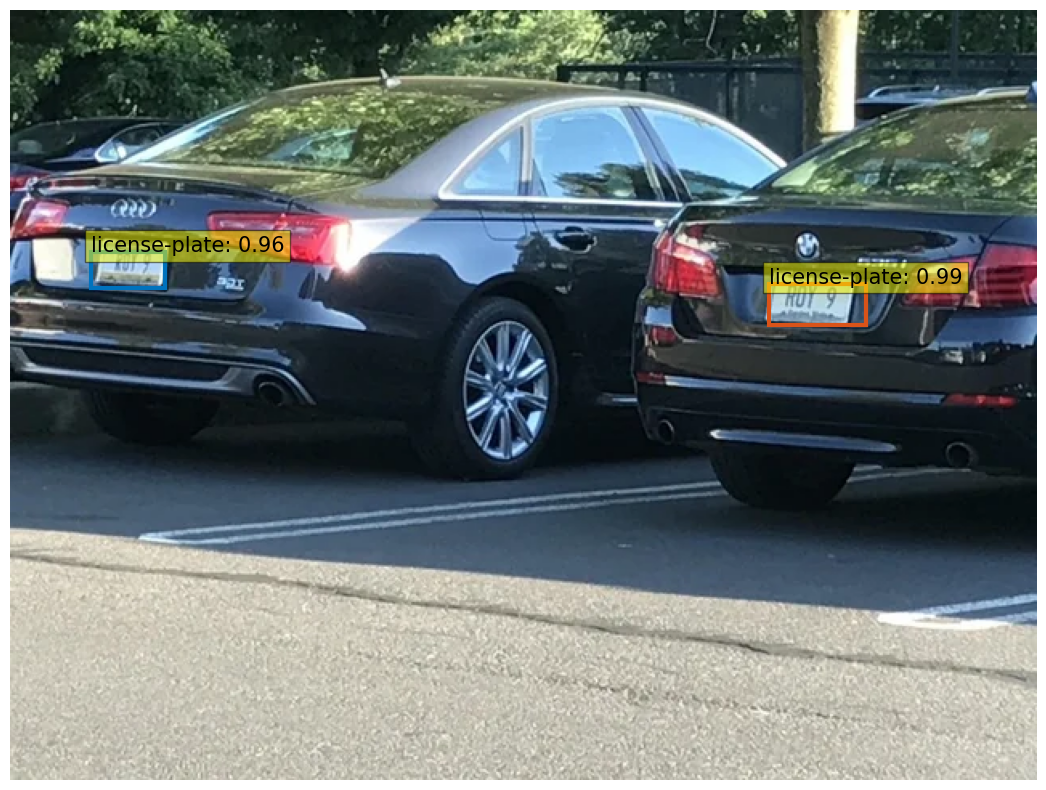

In [23]:
image_path = "/content/example3.png"
image = Image.open(image_path)
scores, boxes = detect(image, model, transform, threshold=0.9)
plot_results(image, scores, boxes)